In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import discogs_client
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import re
import json

import discogs_client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

from typing import Dict, List, Tuple, Optional, Set
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager


In [3]:
# Spotify Client Credentials
CLIENT_ID = "26c65df3e5844f1dbe355d82d80c9f6f"
CLIENT_SECRET = "2d4d2b147bc942b999564a5e8649b987"

In [4]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,
                                                           client_secret=CLIENT_SECRET))

In [5]:
DISCOGS_TOKEN = "FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX"

In [6]:
d = discogs_client.Client(
    'my_user_agent/1.0',
    consumer_key='hZZUdNwRHsUxlgReVdCA',
    consumer_secret='TUAxCaABSkDcmQgeRhIbRRvnHAopOIkH',
    token=u'FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX',
    secret=u'my_token_secret'
)

In [66]:
d.get_authorize_url()

('JTfOijPtVyoofoZuCFkMvzZxhwvjqeMPwBiHjcDY',
 'FmSOtUMYInQRCcMZkhBmqiLVksoKWLUNzMGXgjPg',
 'https://www.discogs.com/oauth/authorize?oauth_token=JTfOijPtVyoofoZuCFkMvzZxhwvjqeMPwBiHjcDY')

In [67]:
d.get_access_token("FJwsqclHeX")

('VCZoAzRfzvAnLcbzZnndWJySibZBjSbWIkEzPHKs',
 'ZOOElKovUzaSKAyoysxesAZgitaBBOrXdlnsHCbq')

In [68]:
me = d.identity()
print(me)

<User 2177455 'oliebab'>


In [69]:
release = d.release(30690634).styles
print(release)

['Breaks', 'Techno', 'Abstract', 'Acid', 'IDM']


In [35]:
import discogs_client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class MusicRecommender:
    def __init__(self, spotify_client_id: str, spotify_client_secret: str, discogs_token: str):
        """Initialize the recommender with API credentials."""
        # Initialize Spotify client
        self.spotify = spotipy.Spotify(
            client_credentials_manager=SpotifyClientCredentials(
                client_id=spotify_client_id,
                client_secret=spotify_client_secret
            )
        )
        
        # Initialize Discogs client
        self.discogs = discogs_client.Client(
            'MusicRecommender/1.0',
            user_token=discogs_token
        )
        
        # Load and prepare reference dataset
        self.reference_df = pd.read_csv('complete/spotify_complete_data.csv')
        
        # Audio features for analysis (removed tempo from visualization features)
        self.audio_features = [
            'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence'
        ]
        # All features including tempo for similarity calculation
        self.all_features = self.audio_features + ['tempo']
    
    def parse_discogs_url(self, url: str) -> Tuple[str, int]:
        """Parse Discogs URL to extract release type and ID."""
        master_pattern = r'/master/(\d+)'
        release_pattern = r'/release/(\d+)'
        
        master_match = re.search(master_pattern, url)
        if master_match:
            return 'master', int(master_match.group(1))
            
        release_match = re.search(release_pattern, url)
        if release_match:
            return 'release', int(release_match.group(1))
            
        raise ValueError("Invalid Discogs URL format")
    
    def get_discogs_info(self, url: str) -> Dict:
        """Get detailed release information from Discogs."""
        release_type, release_id = self.parse_discogs_url(url)
        
        try:
            if release_type == 'master':
                master = self.discogs.master(release_id)
                release = master.main_release
            else:
                release = self.discogs.release(release_id)
            
            # Extract basic information
            info = {
                'artist': release.artists[0].name if release.artists else "Unknown Artist",
                'album': release.title,
                'tracks': [track.title for track in release.tracklist 
                          if track.title and isinstance(track.title, str)],
                'genres': release.genres if hasattr(release, 'genres') else [],
                'styles': release.styles if hasattr(release, 'styles') else [],
                'year': release.year if hasattr(release, 'year') else None,
                'release_id': release_id
            }
            
            # Clean up artist name
            info['artist'] = re.sub(r'\(\d+\)', '', info['artist']).strip()
            
            # Get price statistics through web scraping
            price_stats = self._scrape_price_stats(url)
            info.update(price_stats)
            
            return info
            
        except Exception as e:
            raise Exception(f"Failed to fetch Discogs release: {str(e)}")
    
    def _scrape_price_stats(self, url: str) -> Dict:
        """Scrape price statistics from Discogs webpage using Selenium."""
        stats = {
            'low': None,
            'median': None,
            'high': None
        }
        
        # Configure Selenium to use headless mode
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        
        # Use WebDriver Manager to automatically handle ChromeDriver installation
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

        try:
            # Load the page
            driver.get(url)

            # Wait for the "release-stats" section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "release-stats"))
            )

            # Find the "release-stats" section
            statistics_section = driver.find_element(By.ID, "release-stats")

            # Find all <li> elements with prices in the statistics section
            li_elements = statistics_section.find_elements(By.TAG_NAME, "li")

            for li in li_elements:
                # Find spans within each <li> for the label and price
                spans = li.find_elements(By.TAG_NAME, "span")
                if len(spans) == 2:
                    label = spans[0].text.strip().lower().rstrip(':')
                    value = spans[1].text.strip()

                    # Assign value based on label
                    if 'low' in label:
                        stats['low'] = value
                    elif 'median' in label:
                        stats['median'] = value
                    elif 'high' in label:
                        stats['high'] = value
            
            # Debug output
            print("\nDebug - Price scraping results using Selenium:")
            print("Found prices:", stats)

            return stats

        except Exception as e:
            print(f"Error scraping prices: {str(e)}")
            return {k: 'N/A' for k in ['low', 'median', 'high']}
        
        finally:
            # Close the Selenium driver
            driver.quit()
        
    def get_spotify_features(self, artist: str, album: str) -> Optional[Dict]:
        """Get Spotify audio features and metadata for an album."""
        try:
            # Search for album
            query = f"album:{album} artist:{artist}"
            results = self.spotify.search(q=query, type='album', limit=1)
            
            if not results['albums']['items']:
                return None
                
            album_id = results['albums']['items'][0]['id']
            album_info = self.spotify.album(album_id)
            
            # Get tracks and their audio features
            tracks = self.spotify.album_tracks(album_id)['items']
            track_ids = [track['id'] for track in tracks]
            audio_features = self.spotify.audio_features(track_ids)
            
            # Combine track info with audio features
            tracks_with_features = []
            for track, features in zip(tracks, audio_features):
                if features:
                    track_info = {
                        'name': track['name'],
                        'preview_url': track['preview_url'],
                        **{k: features[k] for k in self.all_features}
                    }
                    tracks_with_features.append(track_info)
            
            return {
                'album_image': album_info['images'][0]['url'] if album_info['images'] else None,
                'tracks': tracks_with_features
            }
            
        except Exception as e:
            print(f"Error getting Spotify features: {e}")
            return None
    
    def visualize_album_features(self, tracks_features: List[Dict]) -> None:
        """Create visualizations for album audio features."""
        # Calculate mean features for radar plot (excluding tempo)
        mean_features = pd.DataFrame(tracks_features)[self.audio_features].mean()
        
        fig = plt.figure(figsize=(15, 5))
        
        # Radar plot (spider plot) for audio features excluding tempo
        ax1 = fig.add_subplot(121, projection='polar')
        angles = np.linspace(0, 2*np.pi, len(self.audio_features), endpoint=False)
        values = mean_features.values
        values = np.concatenate((values, [values[0]]))  # complete the circle
        angles = np.concatenate((angles, [angles[0]]))  # complete the circle
        
        ax1.plot(angles, values)
        ax1.fill(angles, values, alpha=0.25)
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(self.audio_features)
        plt.title("Album Audio Features")
        
        # Tempo bar plot
        ax2 = fig.add_subplot(122)
        tempos = pd.DataFrame(tracks_features)[['name', 'tempo']].sort_values('tempo')
        ax2.barh(tempos['name'], tempos['tempo'])
        ax2.set_xlabel('Tempo (BPM)')
        ax2.set_title('Track Tempos')
        
        plt.tight_layout()
        plt.show()
    
    def style_similarity_score(self, input_styles: List[str], candidate_styles: List[str]) -> float:
        """Calculate similarity score between two sets of styles."""
        if not input_styles or not candidate_styles:
            return 0.0
            
        # Convert to sets for intersection calculation
        input_set = set(s.lower() for s in input_styles)
        candidate_set = set(s.lower() for s in candidate_styles)
        
        # Calculate Jaccard similarity
        intersection = len(input_set.intersection(candidate_set))
        union = len(input_set.union(candidate_set))
        
        return intersection / union if union > 0 else 0.0
    
    def find_similar_tracks(self, tracks_features: List[Dict], input_styles: List[str], 
                          n_recommendations: int = 5) -> pd.DataFrame:
        """Find similar tracks from the reference dataset with style matching and artist diversity."""
        # Prepare feature matrix for input tracks
        input_features = pd.DataFrame(tracks_features)[self.all_features]
        input_mean = input_features.mean().values.reshape(1, -1)
        
        # Prepare reference features
        ref_features = self.reference_df[self.all_features]
        
        # Scale features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(
            pd.concat([ref_features, pd.DataFrame(input_mean, columns=self.all_features)])
        )
        
        # Calculate audio feature similarities
        similarities = cosine_similarity(
            scaled_features[-1:],
            scaled_features[:-1]
        )[0]
        
        # Create DataFrame with similarities
        candidates = self.reference_df.copy()
        candidates['audio_similarity'] = similarities
        
        # Calculate style similarity for each track
        candidates['style_similarity'] = 0.0  # Initialize with zero
        
        # Sort by combined similarity score
        candidates['combined_score'] = candidates['audio_similarity']
        
        # Sort and filter for artist diversity
        recommendations = []
        seen_artists = set()
        
        # Sort by combined score and iterate through candidates
        for _, track in candidates.sort_values('combined_score', ascending=False).iterrows():
            if track['artist_name'] not in seen_artists:
                recommendations.append(track)
                seen_artists.add(track['artist_name'])
                
                if len(recommendations) >= n_recommendations:
                    break
        
        # Convert recommendations to DataFrame
        recommendations_df = pd.DataFrame(recommendations)
        
        return recommendations_df
    
    def analyze_album(self, discogs_url: str) -> Dict:
        """Main analysis function."""
        # Get Discogs information
        print("Fetching Discogs information...")
        discogs_info = self.get_discogs_info(discogs_url)
        
        # Get Spotify features
        print("Fetching Spotify features...")
        spotify_info = self.get_spotify_features(discogs_info['artist'], discogs_info['album'])
        
        if not spotify_info:
            raise ValueError("Could not find album on Spotify")
        
        # Create visualizations
        print("Creating visualizations...")
        self.visualize_album_features(spotify_info['tracks'])
        
        # Find recommendations
        print("Finding similar tracks...")
        recommendations = self.find_similar_tracks(
            spotify_info['tracks'],
            discogs_info['styles']
        )
        
        return {
            'discogs_info': discogs_info,
            'spotify_info': spotify_info,
            'recommendations': recommendations.to_dict('records')
        }

# Example usage
if __name__ == "__main__":
    recommender = MusicRecommender(
        spotify_client_id="26c65df3e5844f1dbe355d82d80c9f6f",
        spotify_client_secret="2d4d2b147bc942b999564a5e8649b987",
        discogs_token="FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX"
    )
    
    # Example Discogs URL
    url = "https://www.discogs.com/release/2619151-Sandwell-District-Feed-Forward"
    
    # Analyze album and get recommendations
    results = recommender.analyze_album(url)
    
    # Print results
    print("\nAlbum Information:")
    print(f"Artist: {results['discogs_info']['artist']}")
    print(f"Album: {results['discogs_info']['album']}")
    print(f"Genres: {', '.join(results['discogs_info']['genres'])}")
    print(f"Styles: {', '.join(results['discogs_info']['styles'])}")
    print(f"Number of tracks: {len(results['discogs_info']['tracks'])}")
    
    print("\nPrice Statistics:")
    print(f"Last Sold: {results['discogs_info']['last_sold']}")
    print(f"Lowest: {results['discogs_info']['lowest']}")
    print(f"Median: {results['discogs_info']['median']}")
    print(f"Highest: {results['discogs_info']['highest']}")
    
    print("\nRecommended Tracks:")
    for i, track in enumerate(results['recommendations'], 1):
        print(f"{i}. {track['track_title']} by {track['artist_name']}")
        print(f"   Audio Similarity Score: {track['audio_similarity']:.2f}")

KeyboardInterrupt: 

In [7]:
# Main App

class MusicRecommender:
    def __init__(self, spotify_client_id: str, spotify_client_secret: str, discogs_token: str):
        """Initialize the recommender with API credentials."""
        # Initialize Spotify client
        self.spotify = spotipy.Spotify(
            client_credentials_manager=SpotifyClientCredentials(
                client_id=spotify_client_id,
                client_secret=spotify_client_secret
            )
        )
        
        # Initialize Discogs client
        self.discogs = discogs_client.Client(
            'MusicRecommender/1.0',
            user_token=discogs_token
        )
        
        # Define audio features
        self.audio_features = [
            'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence'
        ]
        self.all_features = self.audio_features + ['tempo', 'key', 'mode']
        
        # Initialize musical keys
        self.initialize_musical_keys()
        
        # Initialize genre mappings
        self.initialize_genre_mapping()
        
        # Load and prepare reference dataset
        try:
            self.reference_df = pd.read_csv('complete/spotify_complete_data.csv')
            print(f"Successfully loaded dataset with {len(self.reference_df)} tracks")
            
            # Process musical features
            self.process_musical_features()
        except FileNotFoundError:
            raise FileNotFoundError("Could not find spotify_complete_data.csv")
        except Exception as e:
            raise Exception(f"Error processing dataset: {str(e)}")

    def initialize_musical_keys(self):
        """Initialize musical key mappings and relationships."""
        # Spotify key notation (Camelot compatible)
        self.key_map = {
            -1: ['--', 'Unknown'],
            0: ['8B', 'C'],
            1: ['3B', 'C#/Db'],
            2: ['10B', 'D'],
            3: ['5B', 'D#/Eb'],
            4: ['12B', 'E'],
            5: ['7B', 'F'],
            6: ['2B', 'F#/Gb'],
            7: ['9B', 'G'],
            8: ['4B', 'G#/Ab'],
            9: ['11B', 'A'],
            10: ['6B', 'A#/Bb'],
            11: ['1B', 'B']
        }
        
        # Mapping for minor keys
        self.key_map_minor = {
            -1: ['--', 'Unknown'],
            0: ['8A', 'Am'],
            1: ['3A', 'A#m/Bbm'],
            2: ['10A', 'Bm'],
            3: ['5A', 'Cm'],
            4: ['12A', 'C#m/Dbm'],
            5: ['7A', 'Dm'],
            6: ['2A', 'D#m/Ebm'],
            7: ['9A', 'Em'],
            8: ['4A', 'Fm'],
            9: ['11A', 'F#m/Gbm'],
            10: ['6A', 'Gm'],
            11: ['1A', 'G#m/Abm']
        }
        
        # Key compatibility matrix
        self.compatible_keys = {
            -1: range(12),
            0: [11, 1, 5],
            1: [0, 2, 6],
            2: [1, 3, 7],
            3: [2, 4, 8],
            4: [3, 5, 9],
            5: [4, 6, 10],
            6: [5, 7, 11],
            7: [6, 8, 0],
            8: [7, 9, 1],
            9: [8, 10, 2],
            10: [9, 11, 3],
            11: [10, 0, 4]
        }
        
        # Energy levels for keys
        self.key_energy = {
            -1: 0.5,  # Unknown
            0: 0.7,   # C
            1: 0.8,   # C#/Db
            2: 0.6,   # D
            3: 0.7,   # D#/Eb
            4: 0.8,   # E
            5: 0.6,   # F
            6: 0.7,   # F#/Gb
            7: 0.6,   # G
            8: 0.7,   # G#/Ab
            9: 0.8,   # A
            10: 0.7,  # A#/Bb
            11: 0.8   # B
        }

    def process_musical_features(self):
        """Process and normalize musical features in reference dataset."""
        # Process tempo/BPM
        if 'tempo' in self.reference_df.columns:
            self.reference_df['tempo'] = self.reference_df['tempo'].fillna(-1)
            self.reference_df['tempo_normalized'] = self.reference_df['tempo'].apply(
                lambda x: x if x == -1 else (
                    x/2 if x > 160 else (x*2 if x < 80 else x)
                )
            )
        else:
            self.reference_df['tempo'] = -1
            self.reference_df['tempo_normalized'] = -1

        # Process key information
        if 'key' in self.reference_df.columns:
            self.reference_df['key'] = self.reference_df['key'].fillna(-1).astype(int)
        else:
            self.reference_df['key'] = -1

        if 'mode' in self.reference_df.columns:
            self.reference_df['mode'] = self.reference_df['mode'].fillna(1).astype(int)
        else:
            self.reference_df['mode'] = 1

        # Create full key representation
        self.reference_df['key_full'] = self.reference_df.apply(
            lambda row: self.get_full_key(row['key'], row['mode']),
            axis=1
        )

        # Create key compatibility groups
        self.reference_df['key_group'] = self.reference_df.apply(
            lambda row: self._get_key_group(row['key'], row['mode']),
            axis=1
        )

    def initialize_genre_mapping(self):
        """Initialize comprehensive mappings between Discogs styles and electronic music genres."""
        self.style_mappings = {
            # Techno and related styles
            'techno': [
                'techno', 'detroit techno', 'minimal techno', 'acid techno', 
                'industrial techno', 'dub techno', 'hard techno', 'experimental techno',
                'tech house', 'minimal', 'loops & samples', 'tribal', 'warehouse techno',
                'peak time techno', 'hypnotic techno', 'raw techno'
            ],
            
            # House and related styles
            'house': [
                'house', 'deep house', 'tech house', 'acid house', 'minimal house',
                'progressive house', 'tribal house', 'disco house', 'funky house',
                'chicago house', 'microhouse', 'electro house', 'minimal/tech house',
                'soulful house', 'vocal house', 'garage house', 'filter house'
            ],
            
            # Ambient and atmospheric
            'ambient': [
                'ambient', 'dark ambient', 'atmospheric', 'drone', 'soundscape',
                'experimental ambient', 'space ambient', 'ambient techno', 
                'ambient dub', 'downtempo', 'chill out', 'isolationist',
                'fourth world', 'environmental', 'ethereal'
            ],
            
            # Drum and Bass / Jungle
            'drum and bass': [
                'drum and bass', 'dnb', 'jungle', 'atmospheric dnb', 'darkstep',
                'neurofunk', 'jump up', 'liquid funk', 'breakcore', 'intelligent dnb',
                'techstep', 'hardstep', 'drumfunk', 'ragga jungle', 'crossbreed'
            ],
            
            # Industrial and noise
            'industrial': [
                'industrial', 'power electronics', 'noise', 'rhythmic noise',
                'dark ambient', 'experimental', 'industrial techno', 'ebm',
                'power noise', 'industrial noise', 'death industrial',
                'industrial dub', 'ritual industrial', 'tribal industrial'
            ],
            
            # Minimal
            'minimal': [
                'minimal', 'minimal techno', 'microhouse', 'minimal house',
                'clicks & cuts', 'glitch', 'minimal/tech house', 'dub techno',
                'abstract', 'experimental', 'reduced techno', 'loop techno'
            ],
            
            # Electro
            'electro': [
                'electro', 'electronica', 'idm', 'braindance', 'experimental',
                'abstract', 'tech electro', 'electro techno', 'electro-funk',
                'detroit electro', 'electro bass', 'modern electro'
            ],
            
            # Dub and related
            'dub': [
                'dub', 'dub techno', 'deep dub', 'ambient dub', 'dubstep',
                'dub house', 'reggae', 'minimal dub', 'tech dub',
                'dub ambient', 'abstract dub', 'dubbed out'
            ],
            
            # Experimental
            'experimental': [
                'experimental', 'avant-garde', 'abstract', 'musique concrète',
                'sound art', 'noise', 'glitch', 'drone', 'experimental electronic',
                'generative', 'algorithmic', 'modular', 'granular'
            ],
            
            # Breakbeat
            'breakbeat': [
                'breakbeat', 'breaks', 'nu breaks', 'progressive breaks',
                'electro breaks', 'acid breaks', 'breakcore', 'jungle',
                'chemical breaks', 'funky breaks', 'tech breaks'
            ]
        }
        
        # Additional style characteristics
        self.style_characteristics = {
            'deep': ['deep house', 'deep techno', 'deep dub', 'deep minimal'],
            'progressive': ['progressive house', 'progressive trance', 'progressive breaks'],
            'tribal': ['tribal house', 'tribal techno', 'tribal ambient'],
            'dark': ['dark ambient', 'darkstep', 'dark techno', 'dark progressive'],
            'hypnotic': ['hypnotic techno', 'hypnotic minimal', 'hypnotic dub'],
            'atmospheric': ['atmospheric dnb', 'atmospheric techno', 'atmospheric ambient']
        }
        
        # BPM ranges for genres
        self.genre_bpm_ranges = {
            'techno': (120, 140),
            'house': (120, 130),
            'drum and bass': (160, 180),
            'dubstep': (140, 150),
            'trance': (130, 145),
            'ambient': (60, 120),
            'downtempo': (80, 110),
            'breakbeat': (120, 150),
            'electro': (120, 135),
            'minimal': (125, 130)
        }

    def parse_discogs_url(self, url: str) -> Tuple[str, int]:
        """Parse Discogs URL to extract release type and ID."""
        master_pattern = r'/master/(\d+)'
        release_pattern = r'/release/(\d+)'
        
        master_match = re.search(master_pattern, url)
        if master_match:
            return 'master', int(master_match.group(1))
            
        release_match = re.search(release_pattern, url)
        if release_match:
            return 'release', int(release_match.group(1))
            
        raise ValueError("Invalid Discogs URL format")

    def get_discogs_info(self, url: str) -> Dict:
        """Get detailed release information from Discogs."""
        release_type, release_id = self.parse_discogs_url(url)
        
        try:
            if release_type == 'master':
                master = self.discogs.master(release_id)
                release = master.main_release
            else:
                release = self.discogs.release(release_id)
            
            # Extract basic information
            info = {
                'artist': release.artists[0].name if release.artists else "Unknown Artist",
                'album': release.title,
                'tracks': [track.title for track in release.tracklist 
                          if track.title and isinstance(track.title, str)],
                'genres': release.genres if hasattr(release, 'genres') else [],
                'styles': release.styles if hasattr(release, 'styles') else [],
                'year': release.year if hasattr(release, 'year') else None,
                'label': release.labels[0].name if release.labels else "Unknown Label",
                'catalog': release.labels[0].catno if release.labels else "Unknown",
                'format': release.formats[0]['name'] if release.formats else "Unknown Format"
            }
            
            # Clean up artist name
            info['artist'] = re.sub(r'\(\d+\)', '', info['artist']).strip()
            
            # Get price statistics through web scraping
            price_stats = self._scrape_price_stats(url)
            info.update(price_stats)
            
            return info
            
        except Exception as e:
            raise Exception(f"Failed to fetch Discogs release: {str(e)}")

    from typing import Dict
    import requests
    from bs4 import BeautifulSoup

    def _scrape_price_stats(self, url: str) -> Dict:
        """Scrape price statistics from Discogs webpage using Selenium."""
        # Set Chrome options (you can enable headless mode if desired)
        chrome_options = Options()
        #chrome_options.add_argument("--headless")
        
        # Initialize WebDriver using WebDriver Manager
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        
        try:
            # Load the Discogs release page
            driver.get(url)
            
            # Wait for the "release-stats" section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "release-stats"))
            )
            
            # Locate the price statistics section
            price_section = driver.find_element(By.ID, "release-stats")

            # Initialize a dictionary to store price data
            price_info = {'low': None, 'median': None, 'high': None}

            # Locate all <li> elements in the price section containing price stats
            li_elements = price_section.find_elements(By.TAG_NAME, "li")
            
            for li in li_elements:
                # Each <li> should have two spans: one for the label, one for the value
                spans = li.find_elements(By.TAG_NAME, "span")
                if len(spans) == 2:
                    label = spans[0].text.strip().lower()
                    value = spans[1].text.strip()

                    # Map the label to the appropriate field in price_info
                    if 'low' in label:
                        price_info['low'] = value
                    elif 'median' in label:
                        price_info['median'] = value
                    elif 'high' in label:
                        price_info['high'] = value
            
            return price_info

        except Exception as e:
            print(f"Error scraping prices with Selenium: {e}")
            return {'low': None, 'median': None, 'high': None}
        
        finally:
            # Close the Selenium driver
            driver.quit()

   


    def get_spotify_features(self, artist: str, album: str) -> Optional[Dict]:
        """Get Spotify audio features and metadata for an album."""
        try:
            # Search for album
            query = f"album:{album} artist:{artist}"
            results = self.spotify.search(q=query, type='album', limit=1)
            
            if not results['albums']['items']:
                return None
                
            album_id = results['albums']['items'][0]['id']
            album_info = self.spotify.album(album_id)
            
            # Get tracks and their audio features
            tracks = self.spotify.album_tracks(album_id)['items']
            track_ids = [track['id'] for track in tracks]
            audio_features = self.spotify.audio_features(track_ids)
            
            # Combine track info with audio features
            tracks_with_features = []
            for track, features in zip(tracks, audio_features):
                if features:
                    track_info = {
                        'name': track['name'],
                        'preview_url': track['preview_url'],
                        'duration_ms': track['duration_ms'],
                        **{k: features[k] for k in self.all_features}
                    }
                    tracks_with_features.append(track_info)
            
            return {
                'album_image': album_info['images'][0]['url'] if album_info['images'] else None,
                'tracks': tracks_with_features
            }
            
        except Exception as e:
            print(f"Error getting Spotify features: {e}")
            return None

    def visualize_album_features(self, tracks_features: List[Dict]) -> None:
        """Create visualizations for album audio features and track tempos."""
        # Define features for spider plot (explicitly exclude loudness)
        spider_features = [
            'danceability', 'energy', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence'
        ]
        
        # Calculate mean features for radar plot (using only spider plot features)
        mean_features = pd.DataFrame(tracks_features)[spider_features].mean()
        
        # Normalize values between 0 and 1 for radar plot
        scaler = MinMaxScaler()
        mean_features_scaled = pd.Series(
            scaler.fit_transform(mean_features.values.reshape(-1, 1)).flatten(),
            index=mean_features.index
        )
        
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 6))
        
        # Radar plot for audio features
        ax1 = fig.add_subplot(121, projection='polar')
        angles = np.linspace(0, 2*np.pi, len(spider_features), endpoint=False)
        values = mean_features_scaled.values
        values = np.concatenate((values, [values[0]]))  # Complete the polygon
        angles = np.concatenate((angles, [angles[0]]))
        
        ax1.plot(angles, values)
        ax1.fill(angles, values, alpha=0.25)
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(spider_features)
        ax1.set_ylim(0, 1)  # Set fixed scale 0-1
        ax1.set_title("Audio Features Profile")
        
        # Track tempos horizontal bar chart
        ax2 = fig.add_subplot(122)
        track_data = pd.DataFrame(tracks_features)
        
        # Sort by tempo for better visualization
        track_data = track_data.sort_values('tempo')
        
        # Create horizontal bar chart
        ax2.barh(track_data['name'], track_data['tempo'])
        ax2.set_xlabel('Tempo (BPM)')
        ax2.set_title('Track Tempos')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

    def _normalize_bpm(self, bpm: float) -> float:
        """Normalize BPM to standard range."""
        if bpm <= 0:
            return -1
        
        while bpm < 80:
            bpm *= 2
        
        while bpm > 160:
            bpm /= 2
        
        return bpm

    def analyze_bpm_compatibility(self, bpm1: float, bpm2: float) -> float:
        """Calculate BPM compatibility score."""
        if bpm1 <= 0 or bpm2 <= 0:
            return 0.5
        
        bpm1_norm = self._normalize_bpm(bpm1)
        bpm2_norm = self._normalize_bpm(bpm2)
        
        diff = abs(bpm1_norm - bpm2_norm)
        
        if diff <= 2:
            return 1.0
        elif diff <= 4:
            return 0.9
        elif diff <= 6:
            return 0.8
        elif diff <= 8:
            return 0.7
        elif diff <= 10:
            return 0.6
        else:
            return max(0.2, 1 - (diff * 0.05))

    def check_key_compatibility(self, key1: int, key2: int, mode1: int = 1, mode2: int = 1) -> float:
        """Calculate compatibility score between two musical keys."""
        if key1 == -1 or key2 == -1:
            return 0.5
        
        camelot1 = self.key_map[key1][0] if mode1 == 1 else self.key_map_minor[key1][0]
        camelot2 = self.key_map[key2][0] if mode2 == 1 else self.key_map_minor[key2][0]
        
        if camelot1 == camelot2:
            return 1.0
        
        if key2 in self.compatible_keys[key1]:
            return 0.8 if mode1 == mode2 else 0.7
        
        steps = min((key1 - key2) % 12, (key2 - key1) % 12)
        base_score = max(0.2, 1 - (steps * 0.1))
        
        return base_score * 0.9 if mode1 != mode2 else base_score

    def get_full_key(self, key: int, mode: int) -> str:
        """Get full key name including mode."""
        if key == -1:
            return "Unknown"
        
        if mode == 1:
            return self.key_map[key][1]
        else:
            return self.key_map_minor[key][1]

    def _get_key_group(self, key: int, mode: int) -> str:
        """Get key group for compatibility matching."""
        if key == -1:
            return "Unknown"
        
        base_key = key if mode == 1 else (key + 3) % 12
        if base_key in [0, 5, 7]:
            return "Primary"
        elif base_key in [2, 9, 4]:
            return "Secondary"
        else:
            return "Tertiary"

    def calculate_style_similarity(self, input_styles: List[str], reference_style: str) -> float:
        """Calculate similarity between input styles and a reference style."""
        if not input_styles or not reference_style:
            return 0.0
        
        input_related = set()
        for style in input_styles:
            input_related.update(self.get_related_styles(style))
        
        ref_related = self.get_related_styles(reference_style)
        
        max_score = 0.0
        for input_style in input_related:
            for ref_style in ref_related:
                score = fuzz.ratio(input_style, ref_style) / 100.0
                max_score = max(max_score, score)
        
        return max_score

    def normalize_style(self, style: str) -> str:
        """Normalize style string for comparison."""
        normalized = re.sub(r'[^\w\s]', '', style.lower().strip())
        normalized = re.sub(r'\b(and|&)\b', '', normalized)
        return ' '.join(normalized.split())

    def get_related_styles(self, style: str) -> Set[str]:
        """Get related styles for a given style."""
        normalized = self.normalize_style(style)
        related = {normalized}
        
        # Check main style mappings
        for key, values in self.style_mappings.items():
            if any(normalized in self.normalize_style(v) for v in [key] + values):
                related.update(map(self.normalize_style, values))
        
        # Check style characteristics
        for key, values in self.style_characteristics.items():
            if key in normalized or any(normalized in self.normalize_style(v) for v in values):
                related.update(map(self.normalize_style, values))
        
        return related

    def find_similar_tracks(self, tracks_features: List[Dict], input_styles: List[str], 
                      n_recommendations: int = 5) -> pd.DataFrame:
        """Find similar tracks with improved style, BPM, and key matching."""
        try:
            # Calculate mean features of input tracks
            input_features = pd.DataFrame(tracks_features)[self.all_features]
            input_mean = input_features.mean().values.reshape(1, -1)
            
            # Calculate mean BPM and most common key
            input_bpm = input_features['tempo'].mean()
            input_key = input_features['key'].mode()[0]
            input_mode = input_features['mode'].mode()[0]
            
            # Prepare reference features
            ref_features = self.reference_df[self.all_features]
            
            # Print column information for debugging
            print("Available columns:", self.reference_df.columns.tolist())
            print("Required features:", self.all_features)
            
            # Scale features
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(
                pd.concat([ref_features, pd.DataFrame(input_mean, columns=self.all_features)])
            )
            
            # Calculate similarities
            audio_similarities = cosine_similarity(
                scaled_features[-1:],
                scaled_features[:-1]
            )[0]
            
            # Create candidates DataFrame
            candidates = self.reference_df.copy()
            candidates['audio_similarity'] = audio_similarities
            
            # Default style similarity if no genre information is available
            candidates['style_similarity'] = 0.5
            
            # Try to calculate style similarity if column exists
            for style_column in ['genre', 'genres', 'styles', 'track_genre']:
                if style_column in candidates.columns:
                    print(f"Using {style_column} for style matching")
                    candidates['style_similarity'] = candidates[style_column].apply(
                        lambda x: self.calculate_style_similarity(input_styles, str(x))
                    )
                    break
            
            # Calculate BPM and key compatibility
            candidates['bpm_compatibility'] = candidates['tempo'].apply(
                lambda x: self.analyze_bpm_compatibility(input_bpm, x)
            )
            
            candidates['key_compatibility'] = candidates.apply(
                lambda x: self.check_key_compatibility(input_key, x['key'], 
                                                    input_mode, x['mode']),
                axis=1
            )
            
            # Calculate final score
            candidates['final_score'] = (
                candidates['style_similarity'] * 0.4 +
                candidates['audio_similarity'] * 0.3 +
                candidates['bpm_compatibility'] * 0.2 +
                candidates['key_compatibility'] * 0.1
            )
            
            # Filter and sort recommendations
            recommendations = self._get_diverse_recommendations(candidates, n_recommendations, input_styles, input_bpm, input_key)
            
            return recommendations
            
        except Exception as e:
            print(f"Error in find_similar_tracks: {str(e)}")
            raise

    
    def analyze_album(self, discogs_url: str) -> Dict:
        """Main analysis function to process an album and find recommendations."""
        print("Fetching Discogs information...")
        try:
            discogs_info = self.get_discogs_info(discogs_url)
        except Exception as e:
            raise Exception(f"Error fetching Discogs information: {str(e)}")
        
        print("Fetching Spotify features...")
        try:
            spotify_info = self.get_spotify_features(discogs_info['artist'], discogs_info['album'])
            if not spotify_info:
                raise ValueError("Could not find album on Spotify")
        except Exception as e:
            raise Exception(f"Error fetching Spotify features: {str(e)}")
        
        print("\nAlbum Details:")
        print(f"Artist: {discogs_info['artist']}")
        print(f"Album: {discogs_info['album']}")
        print(f"Label: {discogs_info['label']}")
        print(f"Catalog: {discogs_info['catalog']}")
        print(f"Format: {discogs_info['format']}")
        print(f"Year: {discogs_info['year']}")
        print(f"Styles: {', '.join(discogs_info['styles'])}")
        print(f"Number of tracks: {len(spotify_info['tracks'])}")
        
        # Display price information
        print("\nMarket Prices:")
        prices = {k: v for k, v in discogs_info.items() if k in ['low', 'median', 'high']}
        if not any(prices.values()) or all(v in [None, 'N/A'] for v in prices.values()):
            print("No price information available")
        else:
            for key, value in prices.items():
                if value and value != 'N/A':
                    print(f"{key.capitalize()}: {value}")
        
        print("\nGenerating visualizations...")
        try:
            plt.close('all')  # Close any existing plots
            self.visualize_album_features(spotify_info['tracks'])
            plt.show()  # Explicitly show the plots
        except Exception as e:
            print(f"Warning: Could not create visualizations: {str(e)}")
        
        print("\nAnalyzing musical features...")
        try:
            # Print mean BPM and key information
            track_features = pd.DataFrame(spotify_info['tracks'])
            mean_bpm = track_features['tempo'].mean()
            most_common_key = track_features['key'].mode()[0]
            most_common_mode = track_features['mode'].mode()[0]
            key_name = self.get_full_key(most_common_key, most_common_mode)
            
            print(f"Average BPM: {mean_bpm:.1f}")
            print(f"Predominant Key: {key_name}")
            
            # Print audio feature averages
            mean_features = track_features[self.audio_features].mean()
            print("\nAudio Feature Averages:")
            for feature, value in mean_features.items():
                print(f"{feature.capitalize()}: {value:.3f}")
            
        except Exception as e:
            print(f"Warning: Could not analyze all musical features: {str(e)}")
        
        print("\nFinding similar tracks...")
        try:
            # Get available columns in reference dataset
            print(f"Available columns in reference dataset: {', '.join(self.reference_df.columns)}")
            
            recommendations = self.find_similar_tracks(
                spotify_info['tracks'],
                discogs_info['styles']
            )
            
            print("\nFound recommendations:")
            for i, track in enumerate(recommendations.to_dict('records'), 1):
                print(f"\n{i}. {track['track_title']} by {track['artist_name']}")
                print(f"   Style Match: {track.get('style_similarity', 'N/A'):.2f}")
                print(f"   BPM Compatibility: {track['bpm_compatibility']:.2f}")
                print(f"   Key Compatibility: {track['key_compatibility']:.2f}")
                print(f"   Overall Score: {track['final_score']:.2f}")
                print(f"   Reason: {track['recommendation_reason']}")
        except Exception as e:
            raise Exception(f"Error finding recommendations: {str(e)}")
        
        return {
            'discogs_info': discogs_info,
            'spotify_info': spotify_info,
            'recommendations': recommendations.to_dict('records'),
            'analysis': {
                'mean_bpm': mean_bpm,
                'key': key_name,
                'audio_features': mean_features.to_dict()
            }
        }

    def _get_diverse_recommendations(self, candidates: pd.DataFrame, n_recommendations: int, input_styles: List[str], input_bpm: float, input_key: int) -> pd.DataFrame:
        """Get diverse recommendations ensuring artist variety."""
        recommendations = []
        seen_artists = set()
        
        # Higher threshold for electronic music
        score_threshold = 0.5
        qualified_tracks = candidates[candidates['final_score'] > score_threshold]
        
        if len(qualified_tracks) < n_recommendations:
            qualified_tracks = candidates
        
        for _, track in qualified_tracks.sort_values('final_score', ascending=False).iterrows():
            if track['artist_name'] not in seen_artists:
                recommendations.append(track)
                seen_artists.add(track['artist_name'])
                
                if len(recommendations) >= n_recommendations:
                    break
        
        recommendations_df = pd.DataFrame(recommendations)
        recommendations_df['recommendation_reason'] = recommendations_df.apply(
            lambda x: self._generate_recommendation_reason(x, input_styles, input_bpm, input_key),
            axis=1
        )
        
        return recommendations_df


    def _generate_recommendation_reason(self, track: pd.Series, input_styles: List[str], 
                                    input_bpm: float, input_key: int) -> str:
        """Generate detailed explanation for recommendation."""
        reasons = []

        # Style match (if available)
        if 'style_similarity' in track:
            if track['style_similarity'] > 0.8:
                reasons.append("Very close style match")
            elif track['style_similarity'] > 0.6:
                reasons.append("Similar style")

        # BPM compatibility
        bpm_diff = abs(track['tempo'] - input_bpm)
        if bpm_diff <= 2:
            reasons.append("Perfect tempo match")
        elif bpm_diff <= 5:
            reasons.append("Compatible tempo")

        # Key compatibility
        if track['key_compatibility'] > 0.8:
            reasons.append("Harmonically compatible")

        # Audio profile match
        if track['audio_similarity'] > 0.8:
            reasons.append("Very similar sound profile")
        elif track['audio_similarity'] > 0.6:
            reasons.append("Similar sound characteristics")

        # Add specific feature matches if notable
        feature_highlights = []
        for feature in ['energy', 'danceability', 'instrumentalness']:
            if feature in track and track[feature] > 0.7:
                feature_highlights.append(f"high {feature}")
            elif feature in track and track[feature] < 0.3:
                feature_highlights.append(f"low {feature}")

        if feature_highlights:
            reasons.append(f"Matching {', '.join(feature_highlights)}")

        return "; ".join(reasons) if reasons else "General style and audio match"



Successfully loaded dataset with 7523890 tracks
Fetching Discogs information...
Fetching Spotify features...

Album Details:
Artist: Amon Tobin
Album: Permutation
Label: Ninja Tune
Catalog: ZEN36XXV
Format: Vinyl
Year: 2024
Styles: Acid Jazz, Breakbeat, Drum n Bass, Experimental, Trip Hop
Number of tracks: 12

Market Prices:
Low: €23.00
Median: €37.16
High: €47.58

Generating visualizations...


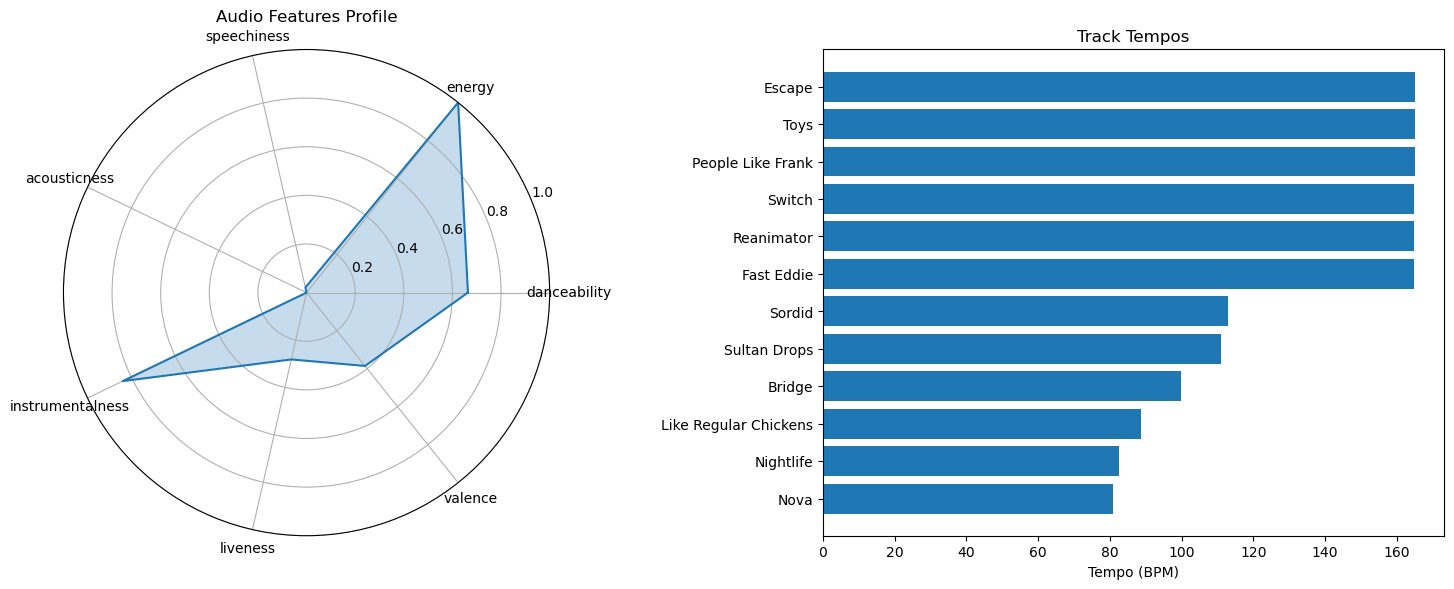


Analyzing musical features...
Average BPM: 130.5
Predominant Key: F#/Gb

Audio Feature Averages:
Danceability: 0.516
Energy: 0.744
Loudness: -9.352
Speechiness: 0.079
Acousticness: 0.064
Instrumentalness: 0.635
Liveness: 0.256
Valence: 0.326

Finding similar tracks...
Available columns in reference dataset: Unnamed: 0, track_id, track_title, duration_ms, isrc, release_id, preview_url, release_title, release_date, upc, popularity, total_tracks, album_type, release_img, label_name, artist_id, artist_name, acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence, tempo_normalized, key_full, key_group
Available columns: ['Unnamed: 0', 'track_id', 'track_title', 'duration_ms', 'isrc', 'release_id', 'preview_url', 'release_title', 'release_date', 'upc', 'popularity', 'total_tracks', 'album_type', 'release_img', 'label_name', 'artist_id', 'artist_name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key',

In [8]:
# Example usage
if __name__ == "__main__":
    recommender = MusicRecommender(
        spotify_client_id="26c65df3e5844f1dbe355d82d80c9f6f",
        spotify_client_secret="2d4d2b147bc942b999564a5e8649b987",
        discogs_token="FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX"
    )
    
    # Example analysis
    url = "https://www.discogs.com/release/30741598-Amon-Tobin-Permutation"
    results = recommender.analyze_album(url)
    
    # Print detailed results
    print("\nAlbum Information:")
    print(f"Artist: {results['discogs_info']['artist']}")
    print(f"Album: {results['discogs_info']['album']}")
    print(f"Label: {results['discogs_info']['label']}")
    print(f"Catalog: {results['discogs_info']['catalog']}")
    print(f"Styles: {', '.join(results['discogs_info']['styles'])}")
    
    print("\nRecommended Tracks:")
    for i, track in enumerate(results['recommendations'], 1):
        print(f"\n{i}. {track['track_title']} by {track['artist_name']}")
        print(f"   Style Match: {track['style_similarity']:.2f}")
        print(f"   BPM Compatibility: {track['bpm_compatibility']:.2f}")
        print(f"   Key Compatibility: {track['key_compatibility']:.2f}")
        print(f"   Overall Score: {track['final_score']:.2f}")
        print(f"   Reason: {track['recommendation_reason']}")

In [73]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

def scrape_price_with_selenium(url: str) -> dict:
    # Configure Chrome options for headless mode (optional)
    chrome_options = Options()
    #chrome_options.add_argument("--headless")
    
    # Set up ChromeDriver using WebDriver Manager
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    
    try:
        # Load the Discogs release page
        driver.get(url)
        
        # Wait for the "release-stats" or equivalent section to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "release-stats"))
        )
        
        # Locate the price statistics section
        price_section = driver.find_element(By.ID, "release-stats")

        # Initialize a dictionary to store price data
        price_info = {'low': None, 'median': None, 'high': None}

        # Locate all <li> elements in the price section containing price stats
        li_elements = price_section.find_elements(By.TAG_NAME, "li")
        
        for li in li_elements:
            # Each <li> should have two spans: one for the label, one for the value
            spans = li.find_elements(By.TAG_NAME, "span")
            if len(spans) == 2:
                label = spans[0].text.strip().lower()
                value = spans[1].text.strip()

                # Map the label to the appropriate field in price_info
                if 'low' in label:
                    price_info['low'] = value
                elif 'median' in label:
                    price_info['median'] = value
                elif 'high' in label:
                    price_info['high'] = value
        
        # Print the results
        print("Scraped price data:", price_info)
        return price_info

    except Exception as e:
        print(f"Error scraping prices with Selenium: {e}")
        return {'low': None, 'median': None, 'high': None}
    
    finally:
        # Close the Selenium driver
        driver.quit()

# Example usage
url = 'https://www.discogs.com/release/30741598-Amon-Tobin-Permutation'
price_data = scrape_price_with_selenium(url)
print(price_data)


Scraped price data: {'low': '€23.00', 'median': '€37.16', 'high': '€47.58'}
{'low': '€23.00', 'median': '€37.16', 'high': '€47.58'}
